# **Imports and Config**

In [ ]:
# === IMPORTS ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, mean_squared_error, r2_score,
    roc_curve, confusion_matrix
)
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

# **Data Loading**

In [ ]:
# === DATA LOADING FUNCTIONS ===
def load_stock_data(file_path):
    """Load stock price data."""
    print(f"Loading stock data from {file_path}...")
    try:
        df = pd.read_csv(file_path)
        df['date'] = pd.to_datetime(df['Local Date'])
        df = df.groupby('date').agg({
            'Close': 'last', 'Open': 'first',
            'High': 'max', 'Low': 'min', 'Volume': 'sum'
        }).reset_index()
        df['Return'] = df['Close'].pct_change().fillna(0)
        df['Direction'] = (df['Return'] > 0).astype(int)
        return df
    except Exception as e:
        print(f"Error loading stock data: {e}")
        return pd.DataFrame()

def load_sentiment_data(file_path):
    """Load sentiment data from FinBERT outputs."""
    print(f"Loading sentiment data from {file_path}...")
    try:
        df = pd.read_csv(file_path, encoding='utf-8')
        if 'Publish date' in df.columns:
            df['date'] = pd.to_datetime(df['Publish date'])
        else:
            date_col = [col for col in df.columns if 'date' in col.lower()][0]
            df['date'] = pd.to_datetime(df[date_col])

        sentiment_col = [col for col in df.columns if 'sentiment' in col.lower()][0]
        daily_sentiment = df.groupby(df['date'].dt.date).agg({
            sentiment_col: ['mean', 'std', 'count']
        }).reset_index()
        daily_sentiment.columns = ['date', 'sentiment_mean', 'sentiment_std', 'sentiment_count']
        daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])
        daily_sentiment.fillna(0, inplace=True)
        return daily_sentiment
    except Exception as e:
        print(f"Error loading sentiment data: {e}")
        return pd.DataFrame()

# **Merge Stock and Sentiment Data**

In [ ]:
def merge_data(stock_df, sentiment_df):
    """Soft merge by nearest date within 1 day."""
    if stock_df.empty or sentiment_df.empty:
        print("Empty data, cannot merge.")
        return pd.DataFrame()

    stock_df['date'] = pd.to_datetime(stock_df['date'])
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

    stock_df = stock_df.sort_values('date')
    sentiment_df = sentiment_df.sort_values('date')

    merged = pd.merge_asof(
        stock_df, sentiment_df,
        on='date', direction='backward',
        tolerance=pd.Timedelta('1D')
    )
    merged.dropna(subset=['sentiment_mean'], inplace=True)
    print(f"Merged data: {merged.shape[0]} rows.")
    return merged

# **Feature Engineering**

In [ ]:
def create_features(df):
    """Create financial and sentiment features without manual feature selection."""
    if df.empty:
        return df, []

    df = df.copy()

    # Financial and Sentiment features
    df['price_range'] = (df['High'] - df['Low']) / df['Open']
    df['price_change'] = (df['Close'] - df['Open']) / df['Open']

    windows = [3, 5]
    for w in windows:
        df[f'ma_{w}'] = df['Close'].rolling(w).mean()
        df[f'volatility_{w}'] = df['Return'].rolling(w).std()
        df[f'volume_change_{w}'] = df['Volume'] / df['Volume'].rolling(w).mean()
        df[f'sentiment_ma_{w}'] = df['sentiment_mean'].rolling(w).mean()
        df[f'sentiment_volatility_{w}'] = df['sentiment_mean'].rolling(w).std()

    df['sentiment_momentum'] = df['sentiment_mean'].diff()
    df['sentiment_price_impact'] = df['sentiment_mean'] * df['price_range']

    df.fillna(0, inplace=True)

    # Use all generated features
    feature_cols = [col for col in df.columns if col not in ['date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Return', 'Direction']]
    print(f"Using all {len(feature_cols)} generated features for XGBoost.")

    return df, feature_cols

# **Prepare Data for Machine Learning**

In [ ]:
def prepare_data(df, feature_columns, target_col='Direction', test_size=0.3, seq_length=3):
    """Prepare ML inputs using only the provided feature columns."""
    if len(df) < 5:
        print("Too few rows after feature creation, skipping.")
        return {}, {}

    # Use only the specified feature columns
    X = df[feature_columns].values
    y = df[target_col].values

    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    ml_data = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test
    }

    return ml_data

# **Train Models**

In [ ]:
# === MODEL TRAINING ===
def train_xgboost(data):
    model = xgb.XGBClassifier(
        n_estimators=50, max_depth=3, learning_rate=0.1,
        objective='binary:logistic', random_state=42
    )
    model.fit(data['X_train'], data['y_train'])
    y_pred = model.predict(data['X_test'])
    y_proba = model.predict_proba(data['X_test'])[:, 1]  # probability for class 1
    return model, y_pred, y_proba


    model = Sequential()
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(data['X_train'], data['y_train'], epochs=epochs, batch_size=2, verbose=0)
    y_pred = model.predict(data['X_test'])
    y_pred_binary = (y_pred > 0.5).astype(int).flatten()
    return model, y_pred_binary

# **Evaluation**

In [ ]:
def plot_roc_curve(y_true, y_proba, model_name="Model"):
    """Plot ROC Curve for classification."""
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_true, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    """Plot Confusion Matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

def evaluate(y_true, y_pred, y_proba=None, model_name="Model"):
    """Evaluate model predictions with full metrics and correct plots."""
    print(f"\n{model_name} Evaluation Metrics:")

    # Basic Classification Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    # AUC if probabilities available
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else "N/A"

    # Regression-style Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # p-value calculation using binomial test
    correct_preds = np.sum(y_true == y_pred)
    n_total = len(y_true)
    pval = stats.binomtest(correct_preds, n_total, p=0.5, alternative='greater').pvalue

    if pval < 1e-4:
        pval_str = f"{pval:.2e}"
    else:
        pval_str = f"{pval:.4f}"

    # === Print Metrics ===
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc if auc == 'N/A' else round(auc,4)}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"p-value: {pval_str}")
    print("\nConfusion Matrix Values:")
    print(confusion_matrix(y_true, y_pred))

    # === Plotting Section ===
    if y_proba is not None:
        plot_roc_curve(y_true, y_proba, model_name)
        plot_confusion_matrix(y_true, y_pred, model_name)

# **Main Function**


Processing xli_cleaned.csv...
Loading stock data from xli_cleaned.csv...
Loading sentiment data from scraped_articles.csv...
Merged data: 6550 rows.
Using all 17 generated features for XGBoost.

XGBoost Evaluation Metrics:
Accuracy: 0.8977
Precision: 0.9141
Recall: 0.8586
F1 Score: 0.8855
AUC: 0.9692
RMSE: 0.3198
R²: 0.5883
p-value: 4.93e-312

Confusion Matrix Values:
[[987  73]
 [128 777]]


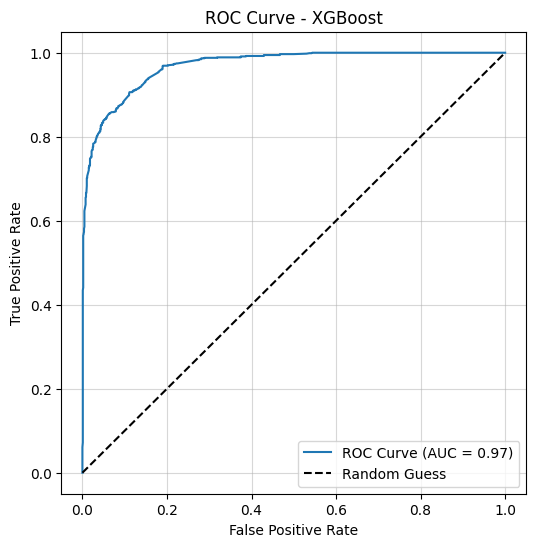

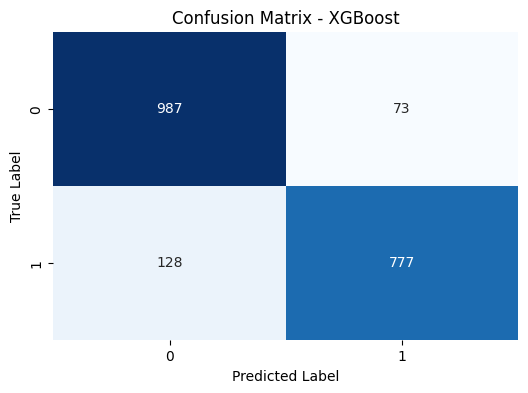


Processing spy_cleaned.csv...
Loading stock data from spy_cleaned.csv...
Loading sentiment data from scraped_articles.csv...
Merged data: 13430 rows.
Using all 17 generated features for XGBoost.

XGBoost Evaluation Metrics:
Accuracy: 0.9104
Precision: 0.9024
Recall: 0.9067
F1 Score: 0.9046
AUC: 0.9692
RMSE: 0.2993
R²: 0.6402
p-value: 0.00e+00

Confusion Matrix Values:
[[1957  185]
 [ 176 1711]]


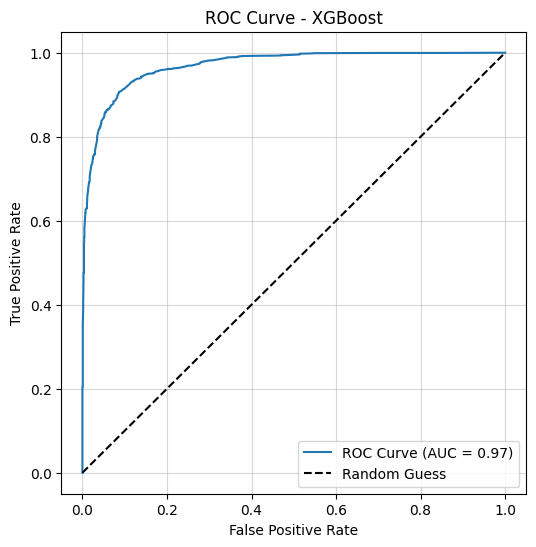

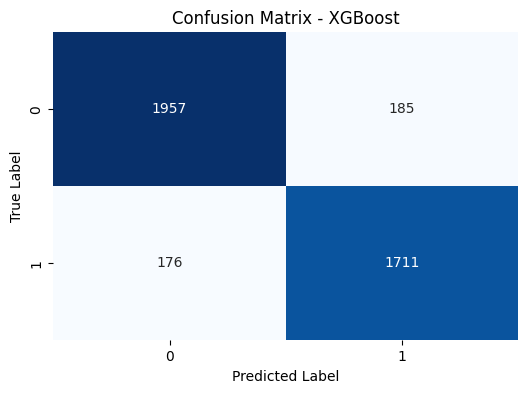


Processing dia_cleaned.csv...
Loading stock data from dia_cleaned.csv...
Loading sentiment data from scraped_articles.csv...
Merged data: 11332 rows.
Using all 17 generated features for XGBoost.

XGBoost Evaluation Metrics:
Accuracy: 0.7968
Precision: 0.8318
Recall: 0.7129
F1 Score: 0.7677
AUC: 0.8854
RMSE: 0.4508
R²: 0.1843
p-value: 2.12e-280

Confusion Matrix Values:
[[1567  231]
 [ 460 1142]]


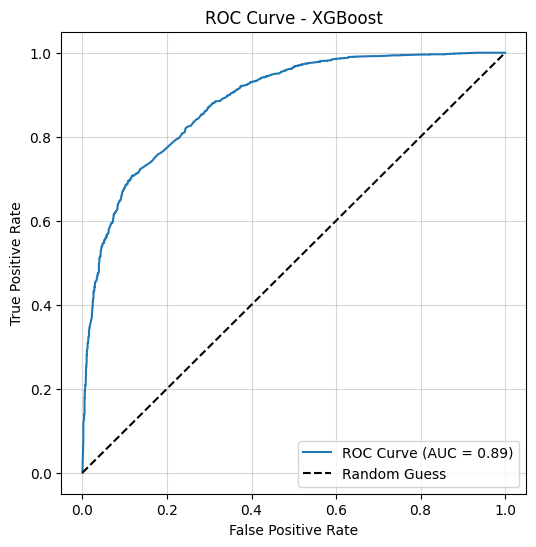

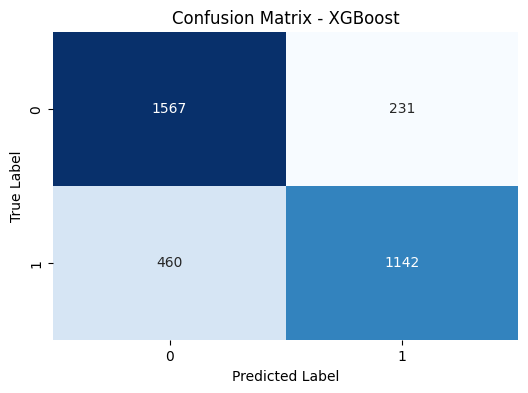

In [ ]:
# === MAIN PROCESS ===
def process_stock(stock_file, sentiment_file):
    stock_df = load_stock_data(stock_file)
    sentiment_df = load_sentiment_data(sentiment_file)
    merged_df = merge_data(stock_df, sentiment_df)

    featured_df, selected_features = create_features(merged_df)   # <-- Now getting selected features
    ml_data = prepare_data(featured_df, selected_features)

    # Train XGBoost
    xgb_model, xgb_pred, xgb_proba = train_xgboost(ml_data)
    evaluate(ml_data['y_test'], xgb_pred, xgb_proba, model_name="XGBoost")

def main():
    sentiment_file = 'scraped_articles.csv'
    stock_files = ['xli_cleaned.csv', 'spy_cleaned.csv', 'dia_cleaned.csv']

    for stock_file in stock_files:
        print(f"\n{'='*40}\nProcessing {stock_file}...\n{'='*40}")
        process_stock(stock_file, sentiment_file)

if __name__ == "__main__":
    main()